In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from config import cfg
cfg.SEQ_LENGTH = 128
cfg.TILE_SIZE = (32,32)
cfg.OUT_SIZE = (16,16)
cfg.TRAIN.BATCH_SIZE = 1
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.NAME = 'gmm'
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 1

In [3]:
def data_generator(gmm_loader,batch_size = cfg.TRAIN.BATCH_SIZE,
                   tile_size = cfg.TILE_SIZE,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()

In [4]:
from loader import TieLoader,GMMDataLoader,draw_sample
gmm_loader = GMMDataLoader(TieLoader('/home/nvvaulin/workspace/movemants/train_ties'),\
                           cfg.TILE_SIZE,cfg.OUT_SIZE,cfg.SEQ_LENGTH)

(128, 3, 32, 32)


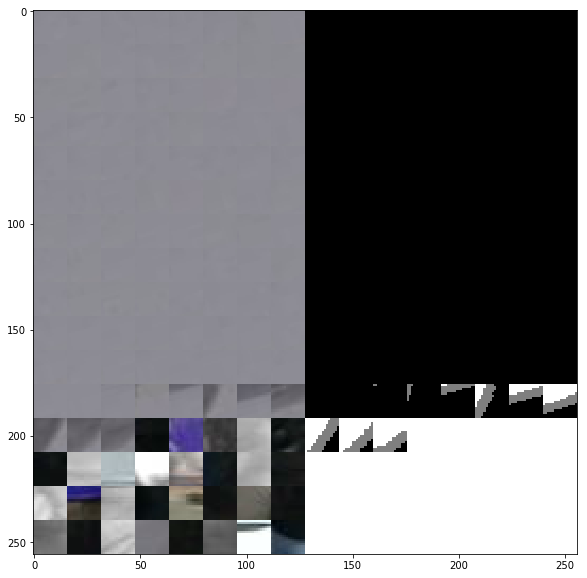

In [5]:

for x,y in data_generator(gmm_loader,1,epoch_size=1):
    print x.shape
    draw_sample(x,y,8,16)
    break

In [6]:
import theano

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


In [7]:
import theano.tensor as T
import lasagne
from lasagne import layers as L
from broadcast import BroadcastLayer,UnbroadcastLayer
from lasagne.nonlinearities import rectify
from lasagne.init import HeNormal,Constant

In [8]:
from symbols import make_conv,BroadcastLayer,res_unit

def gen_unet1(data,num_filters,deep,name='unet',first=True):    
    name = name+str(deep)
    res1 = make_conv(data,num_filters,3,name=name+'_in')   
    
    if(deep == 1):
        return res1
    
    res2 = L.Pool2DLayer(res1,2,name=name+'_pool')
    res2 = gen_unet1(res2,num_filters*2,deep-1,name[:-1],False)
    res2 = L.Deconv2DLayer(res2,num_filters*((2**(deep-1))-1),2,2,crop='valid',nonlinearity=None,name=name+'_deconv')
    res2 = L.BatchNormLayer(res2,name=name+'_deconv_bn')
    res2 = L.NonlinearityLayer(res2,rectify,name=name+'_deconv_rectify')
    res = L.ConcatLayer([res2,res1],axis=1, cropping=(None, None, "center", "center"),name=name+'_concat')
    if(first ):
        res = L.Conv2DLayer(res,num_filters*(2**(deep-1)),3,nonlinearity=None,name=name+'_conv',pad='same')
    else:
        res = make_conv(res,num_filters*(2**(deep-1)),3,name=name+'_out')   
    return res


def make_net(input_tensor):
    data_l = L.InputLayer((cfg.SEQ_LENGTH,3,cfg.TILE_SIZE[1],cfg.TILE_SIZE[0])
                           ,input_tensor
                           ,name='data')
    unet = gen_unet1(data_l,6,3,name='unet')
    return unet
    

In [9]:
from utils import get_network_str,save_weights,load_weights

data = T.tensor4(name='data')
net = make_net(data)
print get_network_str(net,incomings=True,outgoings=True)


In -->     Layer    --> Out    Description                          
-------    -----    -------    -----------                          
[]         0        [1]        data(128, 3, 32, 32)                 
[0]        1        [2]        unet3_in_conv(3)(128, 6, 32, 32)     
[1]        2        [3]        unet3_in_bn(128, 6, 32, 32)          
[2]        3        [4, 22]    unet3_in_relu(128, 6, 32, 32)        
[3]        4        [5]        unet3_pool(128, 6, 16, 16)           
[4]        5        [6]        unet2_in_conv(3)(128, 12, 16, 16)    
[5]        6        [7]        unet2_in_bn(128, 12, 16, 16)         
[6]        7        [8, 15]    unet2_in_relu(128, 12, 16, 16)       
[7]        8        [9]        unet2_pool(128, 12, 8, 8)            
[8]        9        [10]       unet1_in_conv(3)(128, 24, 8, 8)      
[9]        10       [11]       unet1_in_bn(128, 24, 8, 8)           
[10]       11       [12]       unet1_in_relu(128, 24, 8, 8)         
[11]       12       [13]       un

In [10]:
label = T.tensor3(name='label')
Y = label.flatten()
X = lasagne.layers.get_output(net)
X = X[:,:,(cfg.TILE_SIZE[1]-cfg.OUT_SIZE[1])//2:(cfg.TILE_SIZE[1]-cfg.OUT_SIZE[1])//2+cfg.OUT_SIZE[1],\
          (cfg.TILE_SIZE[0]-cfg.OUT_SIZE[0])//2:(cfg.TILE_SIZE[0]-cfg.OUT_SIZE[0])//2+cfg.OUT_SIZE[0]]
X = T.transpose(X,(0,2,3,1)).reshape((cfg.SEQ_LENGTH*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1],-1))
X = X/T.sqrt(T.square(X).sum(1)[:,None])

In [11]:
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import histogram_loss,split,accuracy
from lasagne.regularization import regularize_network_params,l2

In [13]:
_,Yp,Yn = split(X,Y,int(cfg.SEQ_LENGTH*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1]*0.1))
l2_loss = 1e-4 * regularize_network_params(net, l2)

means,covars,_ = get_gmm(X,2,24,True)
p_p = T.transpose(calc_log_prob_gmm_componetwise(Yp,means,covars))
p_n = T.transpose(calc_log_prob_gmm_componetwise(Yn,means,covars))

loss=histogram_loss(p_p[0],p_n[0],1e-3,100)[0]+histogram_loss(p_n[1],p_p[1],1e-3,100)[0]+l2_loss


In [14]:
# outX,outYp,outYn = split(X,Y,int(cfg.SEQ_LENGTH*cfg.OUT_SIZE[0]*cfg.OUT_SIZE[1]*0.1))
# means,covars,weights = get_gmm(outX,cfg.gm_num,24,True)
# p_p = calc_log_prob_gmm(outYp,means,covars,weights)
# p_n = calc_log_prob_gmm(outYn,means,covars,weights)
# l2_loss = 1e-4 * regularize_network_params(net, l2)
# loss = histogram_loss(p_n,p_p,0.0001,200)[0]+l2_loss

In [15]:
params = lasagne.layers.get_all_params(net, trainable=True)
G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
MAX_GRAD_NORM = 15
all_grads = T.grad(loss, params)
all_grads = [T.clip(g, -.1, .1) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(all_grads, MAX_GRAD_NORM, return_norm=True)
updates = lasagne.updates.adam(all_grads,params,G_lr)

In [16]:
train_fn = theano.function([data, label], [loss,accuracy(p_p[0],p_n[0])[0],p_p,p_n,X], allow_input_downcast=True, updates=updates)
print 'train_fn compiled'

train_fn compiled


In [17]:
G_lr.set_value(np.float32(0.001))

In [18]:
#load_weights(net,'models/gmm099_loss1137.18')#models/gmm000_loss17428.31

In [19]:
hard = []
cur = 0

In [ ]:


for j in range(0,100):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(gmm_loader,epoch_size=100)):
        res = train_fn(*batch)
        train_acc += max(res[1],1.-res[1])
        train_loss+=res[0]
#         if(res[0] > 1):
#             if( len(hard) < 1000):
#                 hard.append(batch)
#             else:
#                 hard[cur] = batch
#                 cur = (cur+1) % len(hard)
#         for k in range(min(10,len(hard))):
#             batch = hard[np.random.randint(0,len(hard))]
#             res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f %.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0]),
    print ''
    save_weights(net,'models/%s%03i_loss%05.2f'%\
                 (cfg.NAME,j,train_loss/float(i+1)))
    if(j == 50):
        G_lr.set_value(np.float32(0.0001))
    print ''
#     for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
#         res = test_fn(*batch)
#         train_acc+=res[0]
#     print 'accuracy ',train_acc/10

 epoch 0 batch 16 loss=28573562.87 ,acc=0.70 20738789.28               

# Draw Histogram

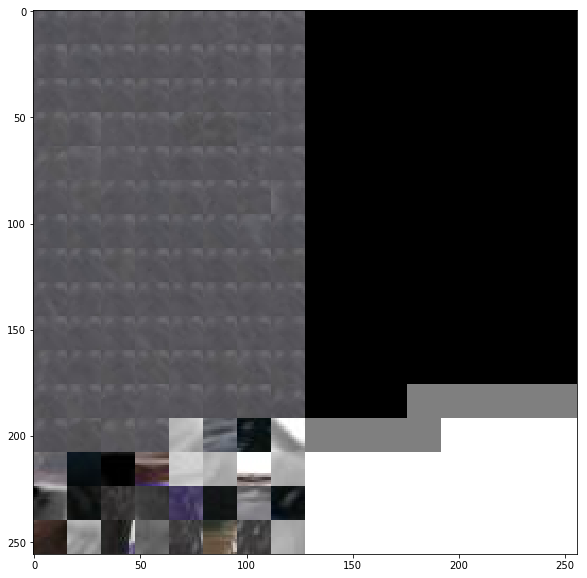

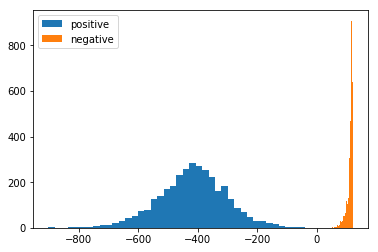

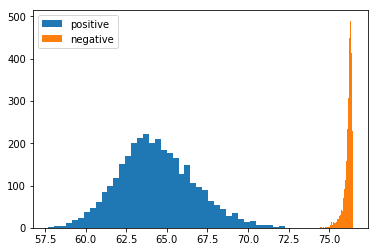

In [22]:
for i,batch in enumerate(data_generator(gmm_loader,epoch_size=10)):
    #batch = hard[10]
    draw_sample(batch[0],batch[1],8,16)
    res = train_fn(*batch)
    plt.hist(res[2][0],bins=40,label='positive')
    plt.hist(res[3][0],bins=40,label='negative')
    plt.legend()
    plt.show()
    
    plt.hist(res[2][1],bins=40,label='positive')
    plt.hist(res[3][1],bins=40,label='negative')
    plt.legend()
    plt.show()
    break

In [83]:
test_acc = 0
for i,batch in enumerate(data_generator(gmm_loader,epoch_size=100)):
    res = test_fn(*batch)
    test_acc += accuracy(res[0],res[1],50)
    print '\r', (test_acc/(i+1)),

0.995500610501                                                        
